In [1]:
import os
import sys

In [2]:
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')

In [3]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
c2p = Cell2PointsConverter(orders=[[4],[4,4]])

In [23]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [24]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(unrisky=True), method='sympy')

Number of equations: 28
Number of degrees of freedom: 45
Strictly stitched_power: 1
Start solving strict part
End solving strict part
NullspaceRank: 17


In [25]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [36]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(unrisky=True),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [ ]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=1)

In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [28]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [33]:
tr_f = np.vectorize(lambda x: (x-1)*x*(x-0.5))

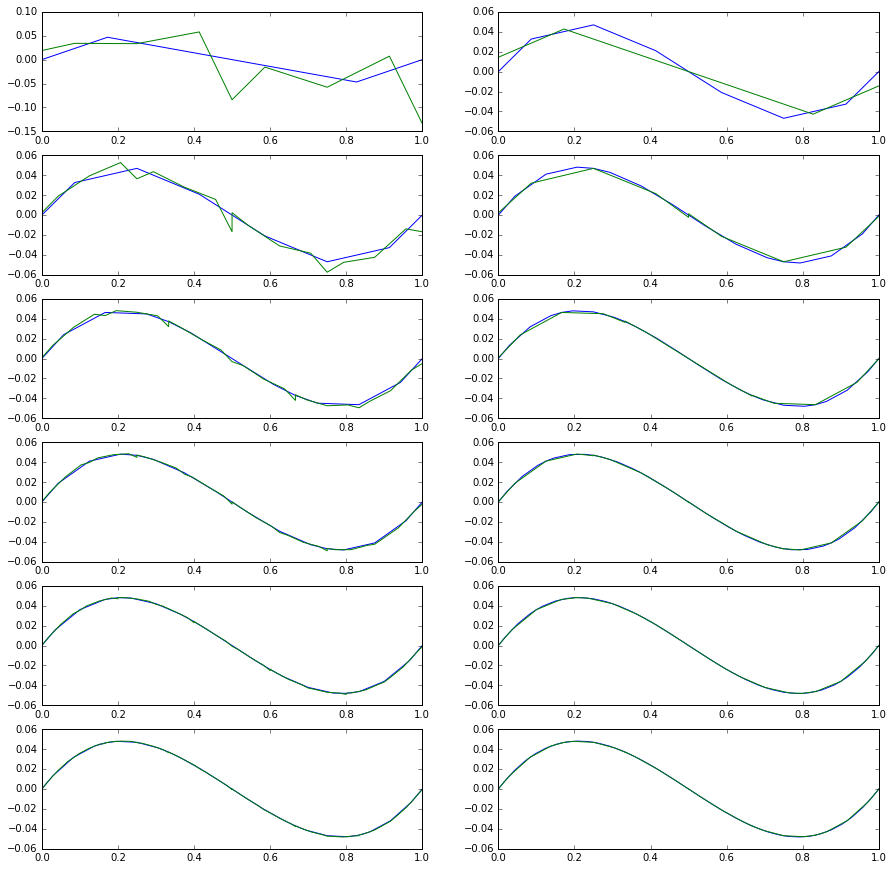

In [34]:
eps_l, eps_r = convergence_test(I_lr=I_lr,
                                I_rl=I_rl,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

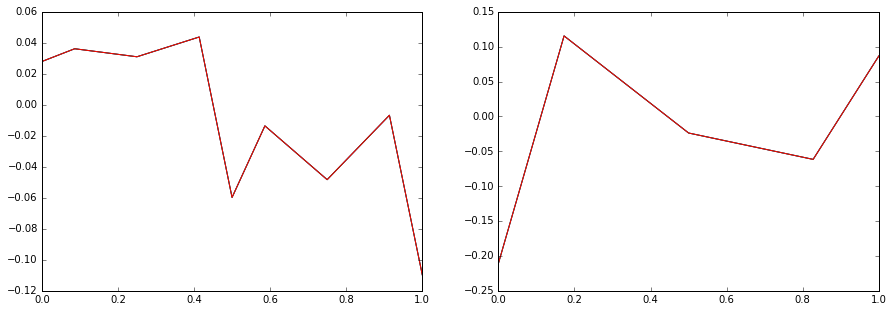

In [35]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

In [ ]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [31]:
np.linalg.eigvals(np.dot(I_lr, I_rl))

array([  4.79090560e+00 +0.00000000e+00j,
         6.03123969e-01 +0.00000000e+00j,
         1.00047901e+00 +0.00000000e+00j,
         9.99985184e-01 +0.00000000e+00j,
         9.99999861e-01 +0.00000000e+00j,
         3.59158156e-17 +1.49601735e-16j,
         3.59158156e-17 -1.49601735e-16j,
         9.21817432e-17 +0.00000000e+00j,  -1.05054318e-17 +0.00000000e+00j])

In [20]:
I_lr

array([[ 1.55936037, -0.28054017, -1.90041095,  3.60454199, -1.98573906],
       [-0.22689151,  1.69123176, -0.32031995, -0.58064186,  0.43289047],
       [ 0.52591287, -0.3781038 ,  1.24027572, -0.47785386,  0.09068957],
       [-0.10495957,  0.35407735,  0.84584592, -0.13830422,  0.04335474],
       [ 0.06674414,  0.27475346, -0.24222726,  1.89745674, -0.99674226],
       [-0.70600271,  1.20421657,  0.18673483,  0.16248087,  0.14790367],
       [ 0.46913058, -0.9202741 ,  0.78481632,  0.86478577, -0.19755229],
       [-0.44745241,  0.84529046, -0.57407403,  0.71124904,  0.46591535],
       [ 1.31598828, -2.45232812,  1.47342848, -0.12708083,  0.79092364]])

In [21]:
I_rl

array([[ 0.77920751, -0.61553464,  1.86879293, -0.28769962,  0.06674414,
        -1.92085733,  1.67612217, -1.22007987,  0.65612738],
       [-0.02478177,  0.84746294, -0.24561918,  0.17703867,  0.05136032,
         0.60212039, -0.60190618,  0.42078   , -0.22371157],
       [-0.13283256, -0.12385142,  0.61967366,  0.3259357 , -0.03275642,
         0.07151316,  0.39240816, -0.21794037,  0.10533257],
       [ 0.32986826, -0.2884507 , -0.31159333, -0.06683084,  0.34662246,
         0.08310962,  0.56277595,  0.35516242, -0.01163013],
       [-0.9910111 ,  1.18021558,  0.32212121,  0.11775199, -0.99674226,
         0.40660834, -0.69742081,  1.26536455,  0.3977805 ]])

In [ ]:
np.dot(I_lr, c2p.get_weights()[0]).sum()

In [ ]:
c2p.get_weights()[0]

In [ ]:
np.dot(I_rl, c2p.get_weights()[1]).sum()

In [ ]:
np.dot(np.dot(c2p.get_diag_weights()[1], I_lr), np.linalg.inv(c2p.get_diag_weights()[0]))

In [ ]:
I_rl.T